In [1]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

C:\Users\balda\AppData\Local\Temp\ipykernel_33720\1749899404.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd   # We import Pandas!
c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initial Processing

In [2]:
# Set your own path
path = 'data/CA_final.csv'

df = pd.read_csv(path)
df.head()

KeyboardInterrupt: 

In [4]:
len(df)

1741433

We've got 1.7M accident records in CA.

In [5]:
df.groupby('Year')['ID'].size()

Year
2016    140452
2017    152748
2018    156898
2019    213455
2020    285532
2021    341876
2022    375913
2023     74559
Name: ID, dtype: int64

In [7]:
df_2022 = df[df['Year'] == 2022]
df_2022.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Hour,Minute,Wind_Speed(mph)_Imputed,Humidity(%)_Imputed,Temperature(F)_Imputed,Visibility(mi)_Imputed,Pressure(in)_Imputed,geohash4,Wind_Direction_Imputed,Weather_Condition_Imputed
175167,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.0,...,2,2,6.0,28.0,86.0,10.0,27.35,9qhh,E,Thunderstorms and Rain
175168,A-512257,Source2,1,2022-09-08 02:02:58,2022-09-08 02:32:20,34.177322,-118.877014,NaN,NaN,0.0,...,2,2,3.0,87.0,68.0,9.0,29.78,9q56,WNW,Thunderstorms and Rain
175169,A-512277,Source2,3,2022-09-07 21:54:19,2022-09-07 22:38:20,38.593945,-121.504059,NaN,NaN,0.0,...,21,54,0.0,28.0,83.0,10.0,29.83,9qce,VAR,Thunderstorms and Rain
175170,A-512340,Source2,2,2022-09-08 02:03:43,2022-09-08 02:33:13,33.850147,-117.875938,NaN,NaN,0.0,...,2,3,0.0,66.0,79.0,10.0,29.76,9qh0,VAR,Thunderstorms and Rain
175171,A-512341,Source3,1,2022-09-08 02:30:59,2022-09-08 03:00:27,33.884056,-118.029007,NaN,NaN,0.0,...,2,30,0.0,66.0,78.0,10.0,29.74,9qh0,VAR,Thunderstorms and Rain


In [8]:
df_2022['Start_Time'].min(), df_2022['Start_Time'].max()

('2022-01-01 00:02:00', '2022-12-31 23:59:00')

In [11]:
# Saving data for 2022 to lighten memory.
save_path = 'data/data_2022.csv'
df_2022.to_csv(save_path)

If you have already saved data for 2022 start here

In [3]:
# Load 2022 data
load_path = 'data/data_2022.csv'
df = pd.read_csv(load_path)

In [4]:
len(df)

375913

In [16]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [5]:
# Creating a time range with index representing consecutive hours in 2022
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)


C:\Users\balda\AppData\Local\Temp\ipykernel_20292\2312101316.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')


In [6]:
hourly_df.head()

,hour,hour_index
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,2
2,2022-01-01 02:00:00,3
3,2022-01-01 03:00:00,4
4,2022-01-01 04:00:00,5


In [24]:
len(hourly_df)

8760

In [7]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [8]:
multi_index_df.head()

,hour,geohash5
0,2022-01-01,9qhh7
1,2022-01-01,9q56q
2,2022-01-01,9qcee
3,2022-01-01,9qh0t
4,2022-01-01,9qh0f


In [57]:
# Step 6: Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

# Step 7: Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

C:\Users\balda\AppData\Local\Temp\ipykernel_20292\3631858385.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')


Let's add one_hot_encoded features for hour of the day and day of the week.

In [58]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# Assuming 'df' is your DataFrame with the structure you provided
# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Step 1: Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # Monday=0, Sunday=6

# Step 2: Generate one-hot encoded columns
hour_dummies = pd.get_dummies(merged_df['hour_of_day'], prefix='hour')
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='day')

# Step 3: Concatenate these new columns to the original DataFrame
merged_df = pd.concat([merged_df, hour_dummies, day_dummies], axis=1)

# Display the final DataFrame
print(merged_df)

                        hour geohash5  accident_count  hour_of_day  \
0        2022-01-01 00:00:00    9qhh7             0.0            0   
1        2022-01-01 00:00:00    9q56q             1.0            0   
2        2022-01-01 00:00:00    9qcee             0.0            0   
3        2022-01-01 00:00:00    9qh0t             0.0            0   
4        2022-01-01 00:00:00    9qh0f             0.0            0   
...                      ...      ...             ...          ...   
63448675 2022-12-31 23:00:00    9r4rr             0.0           23   
63448676 2022-12-31 23:00:00    9r354             0.0           23   
63448677 2022-12-31 23:00:00    9r3q8             0.0           23   
63448678 2022-12-31 23:00:00    9r4n7             0.0           23   
63448679 2022-12-31 23:00:00    9r0wf             0.0           23   

          day_of_week  hour_0  hour_1  hour_2  hour_3  hour_4  ...  hour_21  \
0                   5    True   False   False   False   False  ...    False   
1

There's a lot of hashes and a lot of hours so let's take just one hash for now and try to model it. Going for hash `9q5cw` - one with the most accidents in 2022.

In [180]:
merged_df.to_csv('data/merged_df.csv')

In [2]:
merged_df = pd.read_csv('data/merged_df.csv', index_col=[0])

In [6]:
one_hash_df = merged_df[merged_df['geohash5'] == '9q5cw']

In [7]:
# Update one record
one_hash_df.loc[one_hash_df['hour'] == '2022-01-01', 'hour'] = '2022-01-01 00:00:00'

In [8]:
# Create 2nd order lagged feature columns
one_hash_df['accident_count_lag1'] = one_hash_df['accident_count'].shift(1)
one_hash_df['accident_count_lag2'] = one_hash_df['accident_count'].shift(2)
one_hash_df['accident_count_lag2'] = one_hash_df['accident_count'].shift(3)
one_hash_df['accident_count_lag2'] = one_hash_df['accident_count'].shift(4)
one_hash_df['accident_count_lag2'] = one_hash_df['accident_count'].shift(5)

C:\Users\balda\AppData\Local\Temp\ipykernel_33720\1628237041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_hash_df['accident_count_lag1'] = one_hash_df['accident_count'].shift(1)
C:\Users\balda\AppData\Local\Temp\ipykernel_33720\1628237041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_hash_df['accident_count_lag2'] = one_hash_df['accident_count'].shift(2)
C:\Users\balda\AppData\Local\Temp\ipykernel_33720\1628237041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [9]:
one_hash_df

,hour,geohash5,accident_count,hour_of_day,day_of_week,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6,accident_count_lag1,accident_count_lag2
116,2022-01-01 00:00:00,9q5cw,0.0,0,5,True,False,False,False,False,...,False,False,False,False,False,False,True,False,NaN,NaN
7359,2022-01-01 01:00:00,9q5cw,0.0,1,5,False,True,False,False,False,...,False,False,False,False,False,False,True,False,0.0,NaN
14602,2022-01-01 02:00:00,9q5cw,0.0,2,5,False,False,True,False,False,...,False,False,False,False,False,False,True,False,0.0,NaN
21845,2022-01-01 03:00:00,9q5cw,2.0,3,5,False,False,False,True,False,...,False,False,False,False,False,False,True,False,0.0,NaN
29088,2022-01-01 04:00:00,9q5cw,0.0,4,5,False,False,False,False,True,...,False,False,False,False,False,False,True,False,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63412581,2022-12-31 19:00:00,9q5cw,4.0,19,5,False,False,False,False,False,...,False,False,False,False,False,False,True,False,0.0,2.0
63419824,2022-12-31 20:00:00,9q5cw,3.0,20,5,False,False,False,False,False,...,False,False,False,False,False,False,True,False,4.0,1.0
63427067,2022-12-31 21:00:00,9q5cw,0.0,21,5,False,False,False,False,False,...,False,False,False,False,False,False,True,False,3.0,0.0
63434310,2022-12-31 22:00:00,9q5cw,7.0,22,5,False,False,False,False,False,...,False,False,False,False,False,False,True,False,0.0,2.0


In [10]:
print(len(one_hash_df[one_hash_df['accident_count'] > 0]) / len(one_hash_df) * 100, '% of hourly observations had accident')

21.335616438356166 % of hourly observations had accident


### Load wather data for this cluster.

In [11]:
weather_df = pd.read_csv('data/final_9q5cw.csv')
weather_df = weather_df[['datetime', 'wind_speed', 'height_above_ground_level', 'visibility', 'temperature', 'dew_point']]

In [12]:
weather_df

,datetime,wind_speed,height_above_ground_level,visibility,temperature,dew_point
0,2022-01-01 00:00:00,0.0,22000.0,16093.0,12.80,8.90
1,2022-01-01 01:00:00,0.0,22000.0,16093.0,11.10,8.30
2,2022-01-01 02:00:00,0.0,914.0,16093.0,11.70,8.90
3,2022-01-01 03:00:00,0.0,894.0,16093.0,12.20,6.70
4,2022-01-01 04:00:00,10.5,1280.0,16093.0,11.95,3.65
...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,11.4,237.6,6356.8,15.00,14.20
8756,2022-12-31 20:00:00,0.0,243.9,4103.6,15.54,14.40
8757,2022-12-31 21:00:00,0.0,213.0,14484.0,15.60,14.40
8758,2022-12-31 22:00:00,0.0,274.5,16093.0,15.00,14.40


In [13]:
merged_weather_df = pd.merge(one_hash_df, weather_df, left_on='hour', right_on='datetime', how='left').drop(columns=['datetime'])
merged_weather_df

,hour,geohash5,accident_count,hour_of_day,day_of_week,hour_0,hour_1,hour_2,hour_3,hour_4,...,day_4,day_5,day_6,accident_count_lag1,accident_count_lag2,wind_speed,height_above_ground_level,visibility,temperature,dew_point
0,2022-01-01 00:00:00,9q5cw,0.0,0,5,True,False,False,False,False,...,False,True,False,NaN,NaN,0.0,22000.0,16093.0,12.80,8.90
1,2022-01-01 01:00:00,9q5cw,0.0,1,5,False,True,False,False,False,...,False,True,False,0.0,NaN,0.0,22000.0,16093.0,11.10,8.30
2,2022-01-01 02:00:00,9q5cw,0.0,2,5,False,False,True,False,False,...,False,True,False,0.0,NaN,0.0,914.0,16093.0,11.70,8.90
3,2022-01-01 03:00:00,9q5cw,2.0,3,5,False,False,False,True,False,...,False,True,False,0.0,NaN,0.0,894.0,16093.0,12.20,6.70
4,2022-01-01 04:00:00,9q5cw,0.0,4,5,False,False,False,False,True,...,False,True,False,2.0,NaN,10.5,1280.0,16093.0,11.95,3.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,9q5cw,4.0,19,5,False,False,False,False,False,...,False,True,False,0.0,2.0,11.4,237.6,6356.8,15.00,14.20
8756,2022-12-31 20:00:00,9q5cw,3.0,20,5,False,False,False,False,False,...,False,True,False,4.0,1.0,0.0,243.9,4103.6,15.54,14.40
8757,2022-12-31 21:00:00,9q5cw,0.0,21,5,False,False,False,False,False,...,False,True,False,3.0,0.0,0.0,213.0,14484.0,15.60,14.40
8758,2022-12-31 22:00:00,9q5cw,7.0,22,5,False,False,False,False,False,...,False,True,False,0.0,2.0,0.0,274.5,16093.0,15.00,14.40


## 2. Training

The code I am using here is from exercise 06 Part 2.

In [14]:
# Drop first observations with no available lags
merged_weather_df = merged_weather_df.dropna()

# Define target
y = np.array(merged_weather_df['accident_count'], dtype=np.float16)
X = np.array(merged_weather_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']), dtype=np.float16)

# Split into train and test
N = len(X)
split_idx = int(0.85*N)
X_train = X[:split_idx,:]
y_train = y[:split_idx]
X_test = X[split_idx:,:]
y_test = y[split_idx:]

print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape)

 X_train: (7428, 38) 
 X_test: (1311, 38) 
 y_train: (7428,) 
 y_test: (1311,)


In [15]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_test_mean = X_test.mean(axis=0)

X_train_std = X_train.std()
X_test_std = X_test.std()

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [16]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [17]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [18]:
def poisson_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [19]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

In [20]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 9660.2
[500] ELBO: 8053.8
[1000] ELBO: 7031.2
[1500] ELBO: 7009.9
[2000] ELBO: 6997.8
[2500] ELBO: 6992.6
[3000] ELBO: 6988.6
[3500] ELBO: 6986.2
[4000] ELBO: 6987.4
[4500] ELBO: 6987.6
[5000] ELBO: 6986.5
[5500] ELBO: 6987.1
[6000] ELBO: 6986.6
[6500] ELBO: 6987.0
[7000] ELBO: 6986.6
[7500] ELBO: 6986.5
[8000] ELBO: 6986.8
[8500] ELBO: 6986.2
[9000] ELBO: 6986.8
[9500] ELBO: 6986.8


In [21]:
predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [22]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

# convert back to the original scale
preds = y_hat # no need to do any conversion here because the Poisson model received untransformed y's

corr, mae, rae, rmse, r2 = compute_error(y_test, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: nan
MAE: 0.608
RMSE: 0.908
R2: 0.000


c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\balda\anaconda3\envs\mb_ml\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


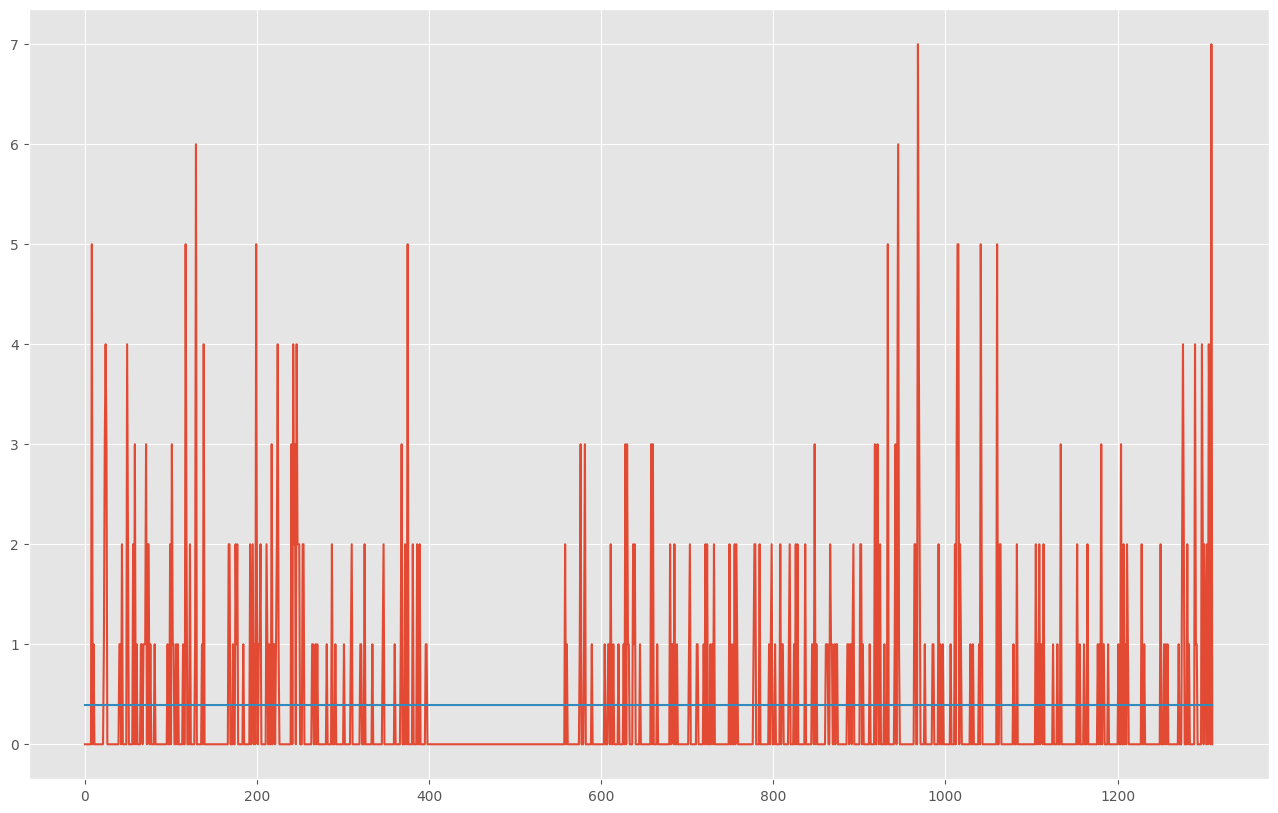

In [23]:
plt.plot(y_test)
plt.plot(preds)